In [1]:
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState, AcrobotParams)
from pydrake.all import Linearize, LinearQuadraticRegulator, SymbolicVectorSystem, Variable, Saturation, \
WrapToSystem, Simulator, Polynomial

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

from IPython.display import SVG, display
import pydot
import numpy as np
import math
import control

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pydrake.forwarddiff as pf
import time

from IPython.display import display, Math, Markdown
from pydrake.examples.pendulum import PendulumPlant
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute, Box
from underactuated import FindResource
from underactuated.scenarios import AddShape

from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression, AddMultibodyPlantSceneGraph)

from pydrake.solvers.mosek import MosekSolver
import sympy as sp
from sympy.physics.vector import dynamicsymbols as dynamicsymbols

In [2]:
mp, mc, l, t, gravity = sp.symbols('mp mc l t gravity')
x, theta, x_dot, theta_dot = dynamicsymbols('x theta x_dot theta_dot')
u = sp.symbols('u')

xdot = sp.diff(x, t)
thetadot = sp.diff(theta, t)
x_ddot = sp.diff(x_dot, t)
theta_ddot = sp.diff(theta_dot, t)

state = sp.Matrix([x, theta, xdot, thetadot])
ctrl_input = sp.Matrix([u])
state_dot = sp.Matrix([x_dot, theta_dot, x_ddot, theta_ddot])

dynamics = sp.Matrix([x_dot - xdot, 
                      theta_dot - thetadot, 
                      (mc+mp)*x_ddot + mp*l*theta_ddot*sp.cos(theta) - mp*l*thetadot**2*sp.sin(theta) - u,
                      mp*l*x_ddot*sp.cos(theta) + mp*l**2*theta_ddot + mp*gravity*l*sp.sin(theta)])


In [3]:
E = dynamics.jacobian(state_dot)
A = dynamics.jacobian(state)
B = dynamics.jacobian(ctrl_input)

In [4]:
E_simp = E.subs([(theta, sp.pi)])

In [5]:
E_simp

Matrix([
[1, 0,       0,       0],
[0, 1,       0,       0],
[0, 0, mc + mp,   -l*mp],
[0, 0,   -l*mp, l**2*mp]])

In [6]:
A_simp = sp.simplify(A.subs([(theta, sp.pi), (thetadot, 0), (xdot, 0), (x, 0)]))

In [7]:
A_simp

Matrix([
[0,             0, -1,  0],
[0,             0,  0, -1],
[0,             0,  0,  0],
[0, -gravity*l*mp,  0,  0]])

In [8]:
B

Matrix([
[ 0],
[ 0],
[-1],
[ 0]])

In [9]:
mp = 1
mc = 1
l = 1
gravity = 9.8

In [10]:
E = np.array([[1, 0, 0, 0], 
             [0, 1, 0, 0], 
             [0, 0, mc+mp, -l*mp], 
             [0, 0, -l*mp, l**2*mp]])

A = np.array([[0, 0, 1, 0], 
             [0, 0, 0, 1], 
             [0, 0, 0, 0], 
             [0, gravity*l*mp, 0, 0]])

B = np.array([[0], [0], [1], [0]])

Q = np.diag([10, 10, 1, 1])
R = [1]

X, L, K = control.care(A, B, Q, R, E=E)

In [11]:
K

array([[-3.16227766, 61.35079271, -5.28624706, 16.16636793]])

In [71]:
def UprightState():
    return np.array([0, np.pi, 0, 0])

def cart_pole_sim(use_new, num_samples, plotting):
    # defining the controller

    x = Variable("x")
    theta = Variable("t")
    xdot = Variable("\dot{x}")
    thetadot = Variable("\dot{t}")
    u_symbolic = Variable("u")
    garbage = Variable("garbage")

    x = np.hstack([x, theta, xdot, thetadot])
    u = -K@(x  - UprightState())
    own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u)

    #defining the system
    exp_dynamics = np.array([xdot, 
                             thetadot, 
                             (1/(mc+mp*(pf.sin(theta))**2))*(u_symbolic + \
                                                mp*pf.sin(theta)*(l*thetadot**2+gravity*pf.cos(theta))),
                             (1/(l*mc+l*mp*(pf.sin(theta))**2))*(-u_symbolic*pf.cos(theta) \
                                -mp*l*thetadot**2*pf.cos(theta)*pf.sin(theta)-(mc+mp)*gravity*pf.sin(theta))])
    system = SymbolicVectorSystem(state=x, input=[u_symbolic], dynamics=exp_dynamics, output=x)



    builder = DiagramBuilder()
    # plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.1)
    # file_name = FindResource("models/cartpole.urdf")
    # Parser(plant).AddModelFromFile(file_name)
    # plant.Finalize()
    # print('Plant Finalised')

    plant = builder.AddSystem(system)
    controller = builder.AddSystem(own_controller)
    builder.Connect(plant.get_output_port(), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0),
                    plant.get_input_port())

    logger = LogVectorOutput(plant.get_output_port(), builder)

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    #plant_context = plant.GetMyMutableContextFromRoot(context)

    # Simulate
    simulator.set_target_realtime_rate(0)
    duration = 10 
    

    XR = np.linspace(-0.3, 0.3, num_samples)
    TR = np.linspace(np.pi - 0.9, np.pi+0.9, num_samples)
    XR1, TR1 = np.meshgrid(XR, TR)

    success_list = np.zeros_like(XR1)

    for i in range(len(XR1)):
        for j in range(len(XR1[i])): 

            context.SetTime(0.)

            trial = np.array([XR1[i, j], TR1[i, j], 0, 0, 0])
            context.SetContinuousState(trial)
            simulator.Initialize()
            simulator.AdvanceTo(duration)

            log = logger.FindLog(context)
            end_state = log.data()[:, -1]
            diff = np.abs(end_state - UprightState())

            tolerance = 5e-2

            if np.sum(diff < np.ones(4)*tolerance) == 4: 
                success_list[i, j] = 1


            if plotting: 
                plt.figure(figsize=(5, 4))
                plt.plot(log.sample_times(), log.data().transpose())
                plt.xlabel('t')
                plt.ylabel('y(t)')
            #print(j)
        
        print(i)
            
    return success_list, TR1, XR1

print('HERE')
success_list, TR1, XR1 = cart_pole_sim(False, 100, False)

HERE
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [72]:
success_list

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [73]:
success_indices = np.where(success_list == 1)

In [74]:
success_indices

(array([ 0,  0,  0, ..., 99, 99, 99]), array([ 0,  1,  2, ..., 97, 98, 99]))

<IPython.core.display.Javascript object>


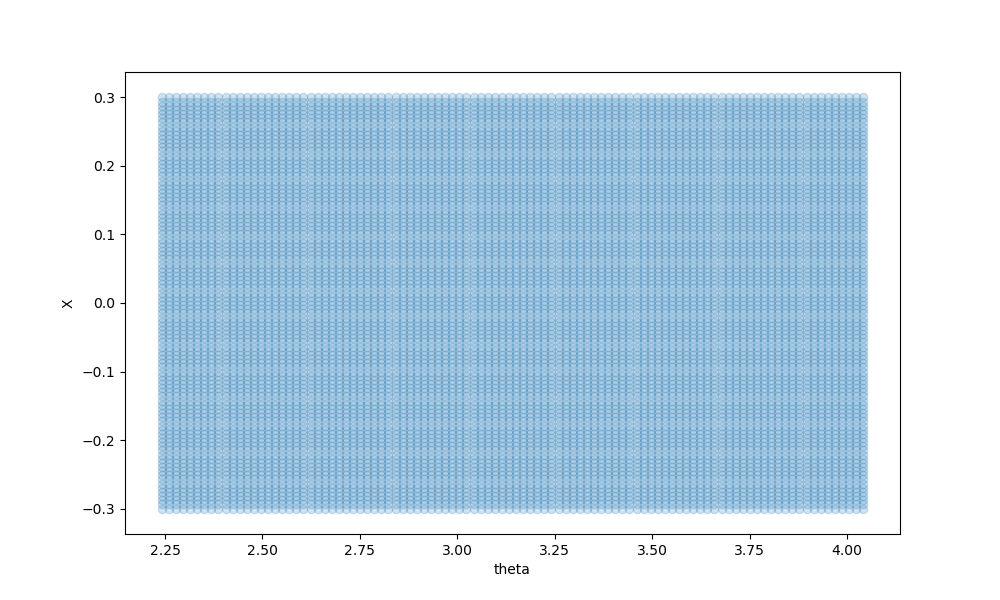

Text(0, 0.5, 'X')

In [75]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

#img2 = ax.scatter(TR1[ckkk2], TR2[ckkk2], alpha=0.2)
img = ax.scatter(TR1[success_indices], XR1[success_indices], alpha=0.2)
# img = ax.scatter(TR1[success_indices_new], TR2[success_indices_new], alpha=0.2)

# Vplot = np.zeros_like(TR1)

# for i in range(len(TR1)):
#     for j in range(len(TR1[i])): 
#         env[s1] = np.sin(TR1[i, j] - np.pi)
#         env[c1] = np.cos(TR1[i, j] - np.pi)
#         env[s2] = np.sin(TR2[i, j])
#         env[c2] = np.cos(TR2[i, j])
#         Vplot[i, j] = V.Evaluate(env)

# ax.contour(TR1,TR2, Vplot, levels=[0.1, 1, 10, 100, 1000])
ax.set_xlabel("theta")
ax.set_ylabel("X")

HI
[-11.     2.36   0.     0.     0.  ]
[-1.96605751e-03  3.14170806e+00  2.44431541e-03  1.44588406e-04]
[0.00196606 0.00011541 0.00244432 0.00014459]
[ True  True  True  True]
3.141708064824919


<IPython.core.display.Javascript object>


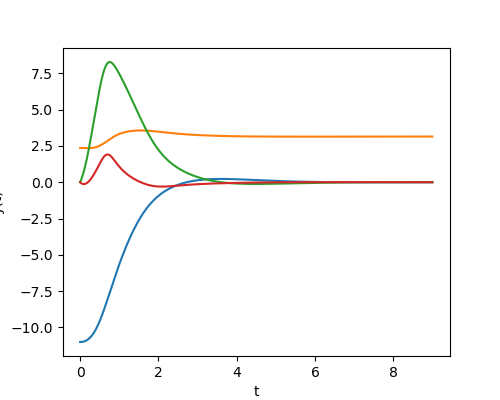

In [16]:
def UprightState():
    return np.array([0, np.pi, 0, 0])

print('HI')
# defining the controller
x = Variable("x")
theta = Variable("t")
xdot = Variable("\dot{x}")
thetadot = Variable("\dot{t}")
u_symbolic = Variable("u")
garbage = Variable("garbage")

x = np.hstack([x, theta, xdot, thetadot])
u = -K@(x  - UprightState())
own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u)

#defining the system
exp_dynamics = np.array([xdot, 
                         thetadot, 
                         (1/(mc+mp*(pf.sin(theta))**2))*(u_symbolic + \
                                            mp*pf.sin(theta)*(l*thetadot**2+gravity*pf.cos(theta))),
                         (1/(l*mc+l*mp*(pf.sin(theta))**2))*(-u_symbolic*pf.cos(theta) \
                                -mp*l*thetadot**2*pf.cos(theta)*pf.sin(theta)-(mc+mp)*gravity*pf.sin(theta))])
system = SymbolicVectorSystem(state=x, input=[u_symbolic], dynamics=exp_dynamics, output=x)



builder = DiagramBuilder()
# plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.1)
# file_name = FindResource("models/cartpole.urdf")
# Parser(plant).AddModelFromFile(file_name)
# plant.Finalize()
# print('Plant Finalised')

plant = builder.AddSystem(system)
controller = builder.AddSystem(own_controller)
builder.Connect(plant.get_output_port(), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0),
                plant.get_input_port())

logger = LogVectorOutput(plant.get_output_port(), builder)

diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
context = simulator.get_mutable_context()
#plant_context = plant.GetMyMutableContextFromRoot(context)

# Simulate
simulator.set_target_realtime_rate(0)
duration = 9

for i in range(1):
    context.SetTime(0.)
#     plant.SetPositionsAndVelocities(
#         plant_context,
#         UprightState() + 0.9 * np.random.randn(4,))
    trial = np.append(UprightState(), 0) - 0.1*np.random.randn(5)
    trial = np.array([-11, 2.36, 0, 0, 0])
    print(trial)
    context.SetContinuousState(trial)
    simulator.Initialize()
    simulator.AdvanceTo(duration)
    
    log = logger.FindLog(context)
    
    end_state = log.data()[:, -1]
    print(end_state)
    diff = np.abs(end_state - UprightState())
    print(diff)
    print(diff < np.ones(4)*5e-2)
    print(log.data()[1][-1])
    plt.figure(figsize=(5, 4))
    plt.plot(log.sample_times(), log.data().transpose())
    plt.xlabel('t')
    plt.ylabel('y(t)')

In [12]:
np.deg2rad(135)

2.356194490192345